In [121]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

# Read Dataset

In [50]:
df = pd.read_csv("AirPassengers.csv", sep=",")
df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values('Month')
df = df.set_index('Month')

df_train = df[:-12].copy()
df_test = df[-12:].copy()

<AxesSubplot:xlabel='Month'>

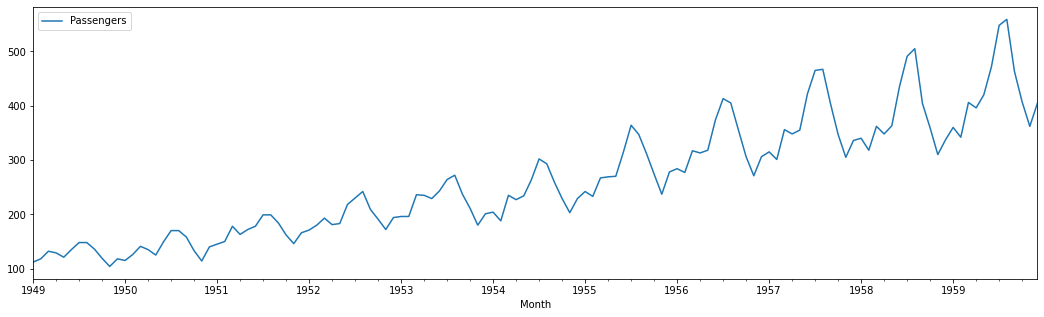

In [60]:
df_train.plot(figsize=(18,5))

<AxesSubplot:xlabel='Month'>

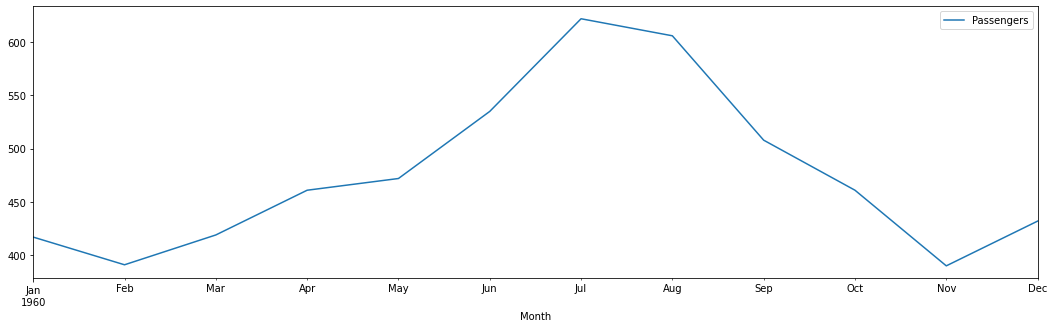

In [59]:
df_test.plot(figsize=(18,5))

Na wykresie danych treningowych można zauważyć pewne zależności. Maksymalna liczba pasażerów jest osiągana latem. Minimalna - na początku i końcu każdego roku.

## Time-series decomposition

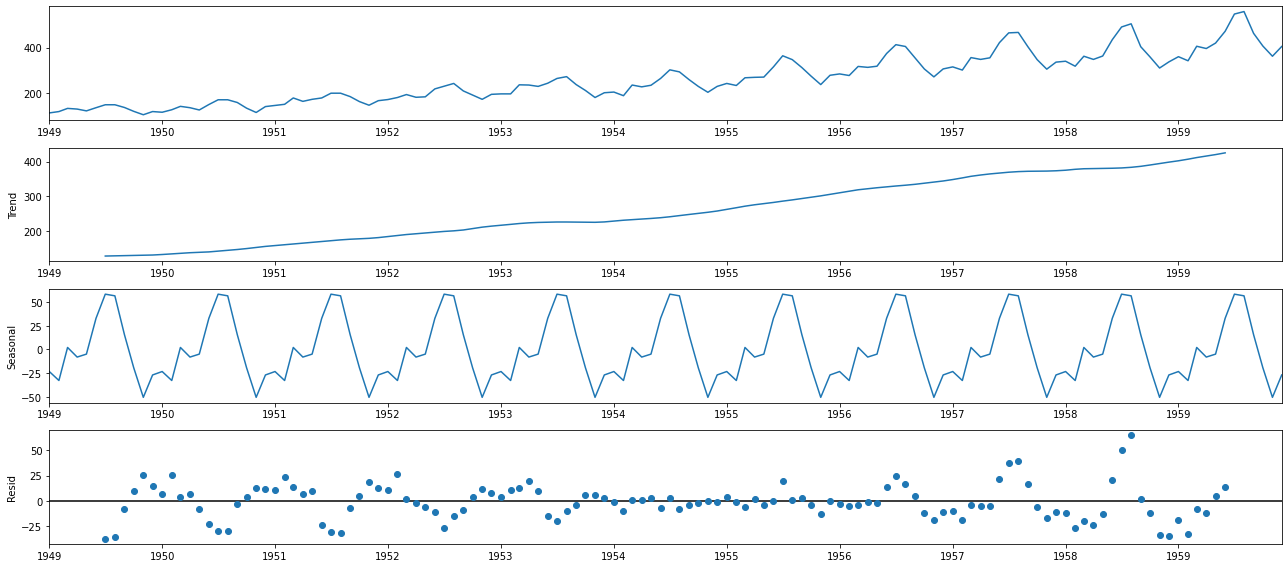

In [107]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_train, model='additive')
fig = decomposition.plot()
plt.show()

Z powyższego wykresu wynika, że liczba pasażerów jest stabilna, zachowuje się linia trendu oraz "sezonowość". 

# Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Spróbuję użyć jeden z najbardziej popularnych algorytmów do predykcji serii czasowych SARIMA. Wyróżnia się tym, że jest odpowiednia dla jednowymiarowych szeregów czasowych z trendem i / lub składnikami sezonowymi. 
Model Sarima składa się z modelu autoregresji (AR), stochastycznego (MA) oraz integracyjnego (I).

Model Sarima przyjmuje kolejne parametry:
* p - seasonality
* d - trend
* q - noise
* m - liczba czsowych kroków dla każdego z sezonów, w naszym przypadku jest równy 12.

## Generowanie zestawu parametrów w celu znalezienia najbardziej optymalnych dla naszego zbioru

In [66]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [156]:
last_aic = None
best_aic_param, best_aic_param_seasonal = None, None
last_mse = None
best_mse_param, best_mse_param_seasonal = None, None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            pred = results.get_prediction(start=pd.to_datetime('1960-01-01'), end=pd.to_datetime('1960-12-01'), dynamic=False)
            mse = mean_squared_error(df_test, pred.predicted_mean)
            aic = results.aic

            if last_aic is None or aic < last_aic:
                last_aic = aic
                best_aic_param = param
                best_aic_param_seasonal = param_seasonal
            
            if last_mse is None or mse <= last_mse:
                last_mse = mse
                best_mse_param = param
                best_mse_param_seasonal = param_seasonal
        except:
            continue

print(f'Best aic 4 SARIMA{best_aic_param}x{best_aic_param_seasonal}12 - AIC:{last_aic}')
print(f'Best aic 4 SARIMA{best_mse_param}x{best_mse_param_seasonal}12 - MSE:{last_mse}')

Best aic 4 SARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:802.8580194673696
Best aic 4 SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MSE:228.97592807427245


Przy znalezionych parametrach wartość miary AIC jest minimalna

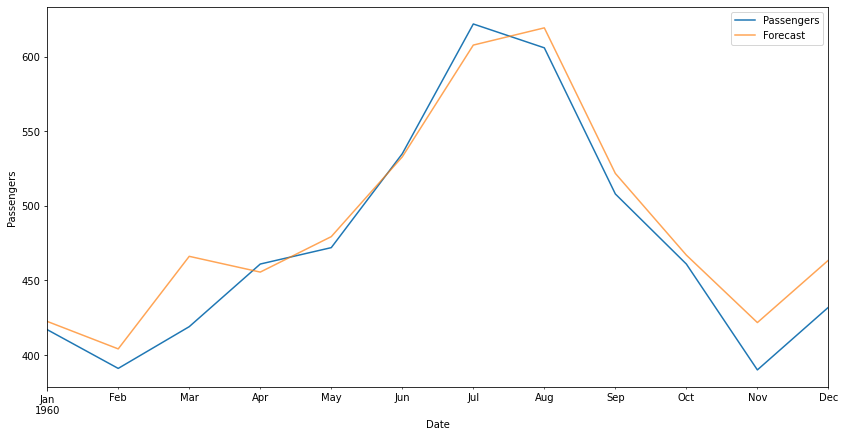

In [157]:
mod = sm.tsa.statespace.SARIMAX(df_train,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

pred = results.get_prediction(start=pd.to_datetime('1960-01-01'), end=pd.to_datetime('1960-12-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_test.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

In [158]:
print('MSE:', mean_squared_error(df_test, pred.predicted_mean))

MSE: 427.0354701810191


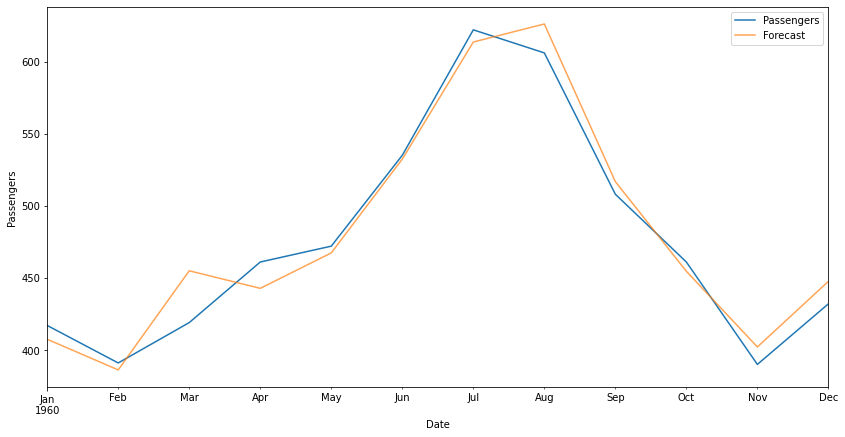

In [159]:
mod = sm.tsa.statespace.SARIMAX(df_train,
                                order=(0, 0, 0),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

pred = results.get_prediction(start=pd.to_datetime('1960-01-01'), end=pd.to_datetime('1960-12-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_test.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

In [160]:
print('MSE:', mean_squared_error(df_test, pred.predicted_mean))

MSE: 228.97592807427245


# ACF and PACF

Mary ACF oraz PACF wskazują na korelacje między wartościami w seriach czasowych. ACF - korelacje pomiędzy instancją obserwowaną w danej chwili a poprzednimi obserwacjami, jak mocno są skorelowane. PACF - 

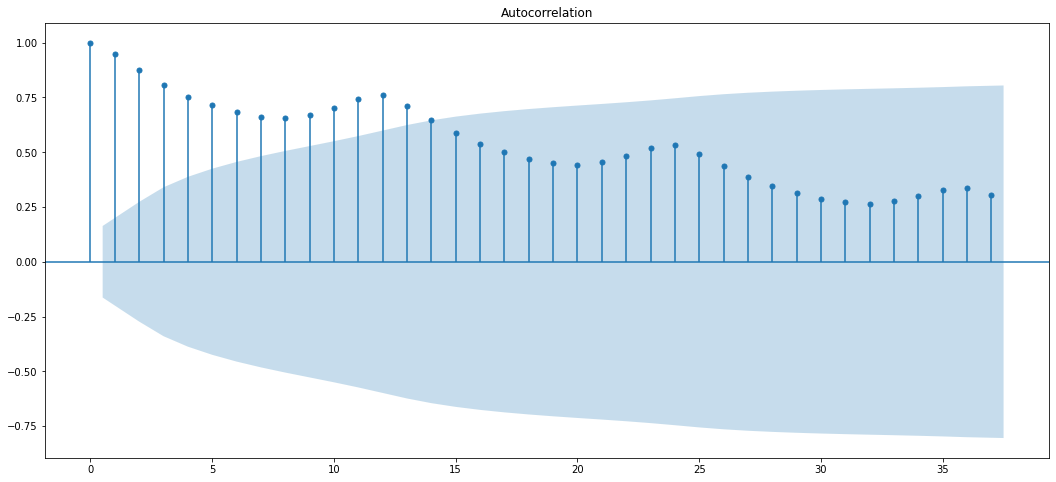

In [177]:
acf_plot = plot_acf(df, lags=37)

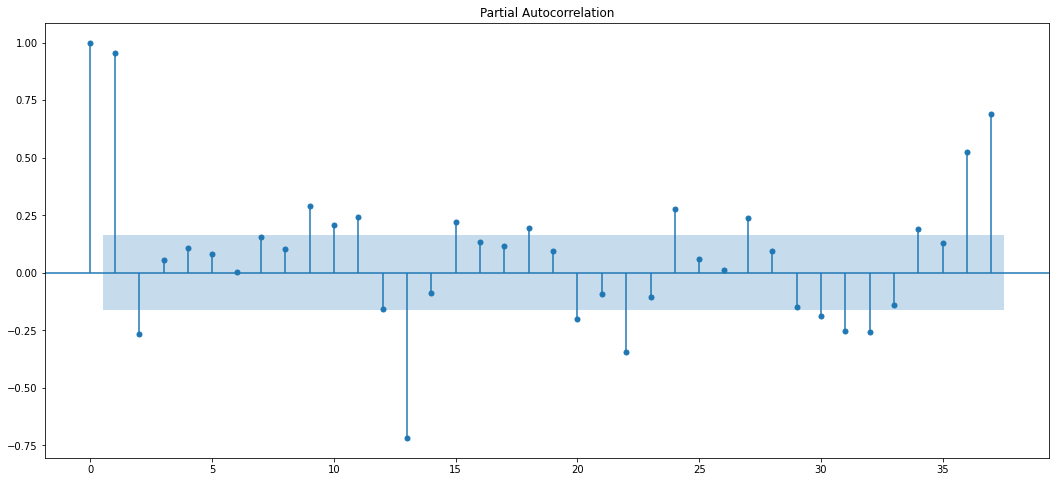

In [174]:
pacf_plot = plot_pacf(df.Passengers, lags=37)

Na wykresie ACF najbardziej można zauważyć rozpad geometryczny co 12 lag. Czyli miara autokorelacji ma największe znaczenia co 12 lag, które stopniowo się zmniejszają: 0, 12, 24, 36... To oznacza, w danych zachodzą sezonowe zależności. 

Bazując na tych wnioskach spróuję przetestować kolejne parametry dla modelu SARIMA: (0,0,0)(1,0,0)12

[Reading the ACF and PACF Plots - The Missing Manual / Cheatsheet](https://www.linkedin.com/pulse/reading-acf-pacf-plots-missing-manual-cheatsheet-saqib-ali/)

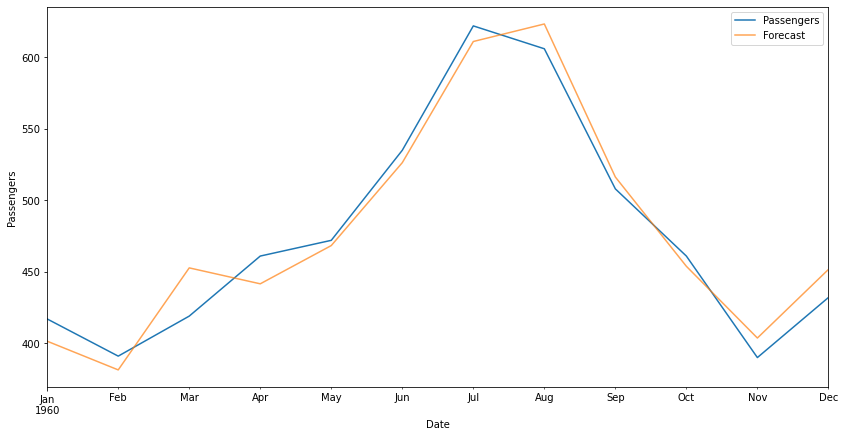

In [180]:
mod = sm.tsa.statespace.SARIMAX(df_train,
                                order=(0, 0, 0),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

pred = results.get_prediction(start=pd.to_datetime('1960-01-01'), end=pd.to_datetime('1960-12-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_test.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

In [181]:
print('MSE:', mean_squared_error(df_test, pred.predicted_mean))

MSE: 254.18222819916025


Można zauważyć, że otrzymano dosyć dobre wyniki. MSE na poziomie 254. Miary ACF oraz PACF służą jako punkt zaczepienia. Więc i tak jest potrzebne dobieranie pozostałych parametrów, chociaż mając podstawową wiedzę na temat sezonowości można bardzo obniżyć czas poszukiwanych wartości. Metodą doboru parametrów uzyskano najlepszy wynik przy SARIMA (0,0,0)(1,0,1)12, MSE wynosi 228. Najgorsze wyniki osiągnięto podaczas doboru porametrów na podstawie miary AIC. Przy znalezionych parametrach (0,1,1)(1,1,1)12 MSE wynosi 427

# Wykorzystane źródła

[11 Classical Time Series Forecasting Methods in Python (Cheat Sheet)](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/)

[An End-to-End Project on Time Series Analysis and Forecasting with Python](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)

[Learn About Time Series ACF and PACF in SPSS With Data From the USDA Feed Grains Database](http://methods.sagepub.com/base/download/DatasetStudentGuide/time-series-acf-pacf-in-us-feedgrains-1876-2015)